In [17]:
# import rasterio as rs
import xarray as xr
import numpy as np
# import cartopy.crs as ccrs
# import cartopy
import matplotlib.pyplot as plt
# import urllib
import glob
# import shutil
import geopandas
# import shapely
import rioxarray
from shapely.geometry import mapping
# import torch
# import time

In [18]:
def clip2connecticut(raster,basin):
    rast = rioxarray.open_rasterio(raster,engine="rasterio")
    r_clip = rast.rio.clip(basin.geometry.apply(mapping),basin.crs)
    r_clip_nonans = np.where(r_clip[0]<0,np.nan,r_clip[0])
    # plt.imshow(r_clip_nonans)
    r_clip.to_netcdf('smap_ee_connecticut_ssm/ct_{}.nc'.format(raster[34:51]))
    
    r_clip_meta = xr.open_dataset('smap_ee_connecticut_ssm/ct_{}.nc'.format(raster[34:51]))
    r_clip_meta = r_clip_meta.rename({'__xarray_dataarray_variable__':'sm_profile'})
    #keep it to single lines for attributes
    r_clip_meta.attrs = {}
    r_clip_meta.attrs['sm_profile'] = "ratio of water to soil optically obtained from SMAP with filtering included" 
    r_clip_meta.attrs['sm_profile_units'] = "%"
    r_clip_meta.attrs['sm_pro_source'] = "https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_SMAP10KM_soil_moisture#citations"
    
    r_clip_meta.to_netcdf('smap_ee_connecticut_ssm/metadata/ct_{}.nc'.format(raster[34:51]))
    
    return r_clip,r_clip_nonans

basin = geopandas.read_file('connecticut_shp/globalwatershed.shp')

smap_soilmoistureprofile_tensor = glob.glob('smap_ssm_ee/tifs/*.tif')
for idx,raster in enumerate(smap_soilmoistureprofile_tensor):
    clip2connecticut(raster,basin)

In [4]:
clip2connecticut(smap_soilmoistureprofile_tensor[0],basin);

In [5]:
clipped_smp = xr.open_dataset('smap_ee_connecticut_smp/metadata/ct_20150402_20150404.nc')
clipped_smp

# plt.imshow(np.where((clipped_smp.sm_profile>0) & (clipped_smp.sm_profile<1) == True,clipped_smp.sm_profile,np.nan)[0])
# plt.colorbar()

<xarray.Dataset>
Dimensions:      (band: 1, x: 15, y: 41)
Coordinates:
  * y            (y) float64 45.23 45.14 45.05 44.95 ... 41.77 41.67 41.58 41.48
  * x            (x) float64 -73.19 -73.05 -72.91 ... -71.51 -71.37 -71.23
  * band         (band) int64 1
Data variables:
    spatial_ref  int64 ...
    sm_profile   (band, y, x) float32 ...
Attributes:
    sm_profile:        ratio of water to soil optically obtained from SMAP wi...
    sm_profile_units:  %
    sm_pro_source:     https://developers.google.com/earth-engine/datasets/ca...

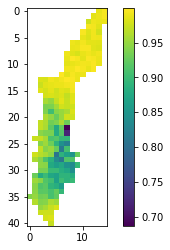

In [11]:
plt.imshow(np.where((clipped_smp.sm_profile>0) & (clipped_smp.sm_profile<1) == True,clipped_smp.sm_profile,np.nan)[0])
plt.colorbar()

In [4]:
import torch
import numpy as np

# https://nwis.waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=09429600&referred_module=sw&period=&begin_date=2015-01-01&end_date=2022-02-26


y = []
with open('ct_streamz.txt','r') as f:
    for x in f:
        y.append(x)
y = np.asarray(y)
print('number of lines in text file',y.shape)

streamflows = y[31:] #gets rid of meta data 
z = []
for idx,x in enumerate(streamflows):
    y = x.split('\t')
    z.append(y)

z = np.asarray(z)
a = np.expand_dims(np.asarray(['Gov Ent','Gage ID','Acq Date','cubic ft/s','unknown']),0)
b = np.vstack((a,z))
# b = b[:-5] #gets rid of dates we don't want
print(b[1],'\n',b[-1])
c = b[1:,3]
d = np.empty((0))
for x in c:
    try:
        d = np.append(d,int(x))
    except:
        print('+1 empty, replaced with -12345678')
        d = np.append(d,-12345678)


x = torch.Tensor([.333,.333,.333]).float()
x = x.unsqueeze(0).unsqueeze(0).unsqueeze(0)
y = torch.from_numpy(d).float().unsqueeze(0).unsqueeze(0).unsqueeze(0)

kernel_height = 1
kernel_width = 3
unfold = torch.nn.Unfold(kernel_size = (kernel_height,kernel_width),stride=(kernel_height,kernel_width))

#using x, you can control what range of days you want to start from
#y is based off of d which is based off of b
#it's streamflow in cubic feet / second
X = 91 #91 in this case is just ninety first in list starting in 2015
arr_unfold = unfold(y[:,:,:,X:]).permute(2,0,1).reshape(-1,1,kernel_height,kernel_width)
streamflow_3day = torch.FloatTensor([torch.mean(x) for x in arr_unfold])

#time column for reference
c = np.asarray(b[1:,2])
streamtime = c.copy()
time_idx = torch.arange(X,c.shape[0]).unsqueeze(0).unsqueeze(0).unsqueeze(0).float()

time_idx_unfold = unfold(time_idx).permute(2,0,1).reshape(-1,1,kernel_height,kernel_width)
dates_of_acquisition = []
for idx,x in enumerate(time_idx_unfold):
    y = f'{streamtime[int(x[0,0,0])]}_{streamtime[int(x[0,0,2])]}'
#     print(y)
    dates_of_acquisition.append(y)
#     print(streamtime[int(x[0,0,0])],'_',streamtime[int(x[0,0,2])])

streamflow_ship = np.transpose(np.vstack((np.expand_dims(dates_of_acquisition,0),np.expand_dims(streamflow_3day,0))))
streamflow_ship_txt = [str(x) for x in streamflow_ship]
print(streamflow_ship_txt[0])
# for idx,x in enumerate(streamflow_ship):
#     print(idx,x)
    
txt_file = open("streamflow_3day_ct_for_neuralnet.txt","w")
for idx,x in enumerate(streamflow_ship_txt):
    txt_file.write(f'{idx} {x} \n')
txt_file.close()
print('CHECKPOINT!')

streamz = np.expand_dims(np.float32(streamflow_ship[:,1]),1)
streamz_tensor = torch.from_numpy(streamz).unsqueeze(1).unsqueeze(1)
torch.save(streamz_tensor,'ct_streamz.pt')

number of lines in text file (2645,)
['USGS' '01193050' '2015-01-01' '33400' 'A\n'] 
 ['USGS' '01193050' '2022-02-26' '49300' 'P\n']
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
+1 empty, replaced with -12345678
['2015-04-02_2015-04-04' '22466.666']
CHECKPOINT!


In [7]:
import time
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import transforms, models

# from random import choice
# from torch.utils.data import random_split
# from sklearn.metrics import mean_squared_error
# import pytorch_ssim
# import arrow
from torchinfo import summary
from datetime import datetime
from pytz import timezone
import scipy.ndimage

east = timezone('US/Eastern')

In [8]:
torch.cuda.empty_cache()
torch.cuda.current_device()
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [10]:
def nc2torch(i):
    return torch.from_numpy(np.asarray(i)).unsqueeze(0)

# m = xr.open_dataset('smap_ee_miss_smp_metadata/miss_20190505_20190507.nc')
# w = xr.open_dataset('smap_ee_miss_smp_metadata/miss_20150402_20150404.nc')
# m1 = nc2torch(m.sm_profile)
# w1 = nc2torch(w.sm_profile)

In [19]:
x = glob.glob('smap_ee_connecticut_ssm/metadata/*.nc')
xx = xr.open_dataset(x[0])

# y = torch.load('ct_streamz.pt')
# print(y.shape)

dset = torch.empty([0,1,xx.y.shape[0],xx.x.shape[0]])
t2 = []

for x in sorted(glob.glob('smap_ee_connecticut_ssm/metadata/*.nc')):
    t0 = time.time()
    y = xr.open_dataset(x)
    z = nc2torch(y.sm_profile)
    dset = torch.cat((dset,z))
    t1 = time.time()
    t2.append(t1-t0)
#     break
print(dset.shape)

torch.save(dset,'connecticut_ssm_imz.pt')

x = torch.load('connecticut_ssm_imz.pt')
print('connecticut images shape',x.shape)

15
torch.Size([841, 1, 41, 15])
connecticut images shape torch.Size([841, 1, 41, 15])


<class 'torch.Tensor'>


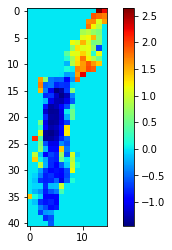

In [16]:
zscored_imz = []
for idy,y in enumerate(x):
    y = y.numpy()
    y = np.where((y>0) & (y<1) == True,y,np.nan)
    np_nanmean = np.nanmean(y)
    np_nanstd = np.nanstd(y)
    zscored = (y-np_nanmean)/np_nanstd
    zscored = np.where(np.isfinite(zscored) == False, 0, zscored)
    zscored_imz.append(zscored)
zscored_imz = torch.from_numpy(np.asarray(zscored_imz))
print(type(zscored_imz))

torch.save(zscored_imz,'zscored_connecticut_imz.pt')

plt.imshow(zscored_imz[0,0],cmap='jet')
plt.colorbar()

In [5]:
class setter(Dataset):
    def __init__(self,x,y,z):
        self.xog = torch.load(x)[:z]
        self.yog = torch.load(y)[:z]
        self.std,self.mean = torch.std_mean(self.yog)

        print('std',self.std)
        
        self.yog = (self.yog - self.mean)/self.std
        print(self.yog[0])
        
        print('shape of x',self.xog.shape)
        print('shape of y',self.yog.shape)
        
        self.x = self.xog.reshape(self.xog.shape[0],self.xog.shape[2]*self.xog.shape[3])
        self.y = self.yog.reshape(self.yog.shape[0],self.yog.shape[3])
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)
        return x, y
    def __len__(self):
        return self.x.shape[0]

class MLP(torch.nn.Module):
    def __init__(self,im_height,im_width):
        super(MLP,self).__init__()
        self.fci = torch.nn.Linear(im_height * im_width,60)
        self.fco = torch.nn.Linear(60,1)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        # self.dropout = torch.nn.Dropout(0.5)

    def forward(self,x):
        x = self.relu(self.fci(x.view(x.size(0),-1)))
        x = self.fco(x)
        return x

class setter2(Dataset):
    def __init__(self,x,y,z):
        self.x = torch.load(x)[:z]
        self.y = torch.load(y)[:z]
        self.std,self.mean = torch.std_mean(self.y)

        print('std',self.std)
        
        self.y = (self.y - self.mean)/self.std
        print(self.y[0])
        print('shape of x',self.x.shape)
        print('shape of y',self.y.shape)
        
        # self.x = self.xog.reshape(self.xog.shape[0],self.xog.shape[2]*self.xog.shape[3])
        self.y = self.y.reshape(self.y.shape[0],self.y.shape[3])
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)
        return x, y
    def __len__(self):
        return self.x.shape[0]

class LARSONet(nn.Module):
    def __init__(self):
        super(LARSONet,self).__init__()
#         # in layer
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1, bias=False)
        self.relu = torch.nn.ReLU(inplace=True)
        # hidden layers
        hidden_layers = []
        for i in range(15):
            hidden_layers.append(torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
            hidden_layers.append(torch.nn.BatchNorm2d(64))
            hidden_layers.append(torch.nn.ReLU(inplace=True))
        self.mid_layer = torch.nn.Sequential(*hidden_layers)
        # out layer
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=1, bias=False) #anything below this is for shrinking 
        
        self.linear1 = torch.nn.Linear(131*79,100)
        self.linear2 = torch.nn.Linear(100,50)
        self.linear3 = torch.nn.Linear(50,20)
        self.linear4 = torch.nn.Linear(20,10)
        self.linear5 = torch.nn.Linear(10,1)

    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out = self.mid_layer(out1)
        o = self.conv3(out)
#         print('output from conv layer', o.shape)
        o = self.relu(self.linear1(o.view(o.size(0),-1)))
        o = self.relu(self.linear2(o))
        o = self.relu(self.linear3(o))
        o = self.relu(self.linear4(o))
        o = self.linear5(o)
        return o

    
# nn_ds_size = 1000
dset = setter('zscored_connecticut_imz.pt','ct_streamz.pt',841)
cube_height = dset.xog.shape[2]
cube_width = dset.xog.shape[3]
epochs=20
batch_size=2
# train_dset_size = int(0.85*len(dset))
# valid_dset_size = int(len(dset) - train_dset_size)
# train_dset, valid_dset = random_split(dset,[train_dset_size,valid_dset_size])

train = Subset(dset,range(0,673))
valid = Subset(dset,range(673,841))


train_dataloader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset=valid, batch_size=batch_size, shuffle=True)
model = LARSONet()
model = MLP(cube_height,cube_width)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = torch.nn.MSELoss(reduction='mean')
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=150,verbose=False)


print('training started at {}'.format(datetime.now(east).strftime('%Y-%m-%d %H:%M:%S')))
t_loss = []
v_loss = []
e_time = []
t0 = time.time()
for i in range(epochs):
    t_e_loss = 0
    v_e_loss = 0
    t00 = time.time()
    model.train()
    for idx,(x,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted = model(x)
#         print(predicted[0])
        loss = criterion(predicted.reshape(-1),y.reshape(-1))
        loss.backward()
        optimizer.step()
        t_e_loss += loss.item()
    for xx,yy in valid_dataloader:
        v_pred = model(xx)
        loss2 = criterion(v_pred.reshape(-1),yy.reshape(-1))
        v_e_loss += loss2.item()
    t_loss.append(t_e_loss/len(train_dataloader))
    v_loss.append(v_e_loss/len(valid_dataloader))
    t11 = time.time()
    e_time.append(t11-t00)
t1 = time.time()
print('training time {} minutes'.format(np.format_float_positional((t1-t0)/60,precision=5)))

fig = plt.figure()
fig.add_subplot(211)
plt.title('insert title here dude',fontsize=9)
plt.plot(t_loss)
plt.plot(v_loss)
plt.legend(['t','v'])
plt.ylabel('mse')
fig.add_subplot(212)
plt.title('time',fontsize=9)
plt.tight_layout()
plt.plot(e_time,color='red')
# plt.plot(np.cumsum(e_time),color='green')
plt.legend(['/epoch (sec)','cum (min)'])

AttributeError: 'str' object has no attribute 'numpy'